In [2]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install hyperopt

     |████████████████████████████████| 14.6 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 31.6 MB/s eta 0:00:01
     |████████████████████████████████| 964 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 22.5 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 31.0 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 9.5 MB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 24.5 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=3180150b8ddfe82684a853132ba3a30c1b46cd22f13bc4d21e32eb1703dab7a1
  Stored in directory: /home/jovyan/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future


### Marcin Wierzbiński -  Distributed Asynchronous Hyper-parameter Optimization Python library Hyperopt

### Hyperopt: A Python Library for Optimizing the Hyperparameters of Machine Learning Algorithms
Background

* Sequential model-based optimization (also known as Bayesian optimization).
* the most efficient methods (per function evaluation) off function minimization.
* Aim: optimizing the hyperparameters of machine learning algorithms that are slow to train. 

* Hyperopt uses the Tree Parzen Estimator (TPE).

## How does it work?

Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

![BayesianOptimization in action](https://raw.githubusercontent.com/fmfn/BayesianOptimization/master/examples/bo_example.png)

### There are four parts to an optimization problem:

1.   Objective function: what we want to minimize
2.   Domain space: values of the parameters over which to minimize the objective
3.   Hyperparameter optimization function: constructs the surrogate function and chooses next values to evaluate
4.   Trials: score, parameter pairs recorded each time we evaluate the objective function


### Objective function
* Objective function, we must make sure it returns a single real-value number to minimize. 
* If we use a metric such as accuracy, then we would have to return the negative of accuracy to tell our model to find a better accuracy!

* **We can also return a dictionary (we will see this later)** where one of the keys must be "loss". Here we will just return the output of the function $f(params)$

Example:


In [19]:
from timeit import default_timer as timer
from hyperopt import STATUS_OK

def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object

    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])
    
    start = timer()
    loss = f(x) * 0.05
    end = timer()
    
    # Calculate time to evaluate
    time_elapsed = end - start
    
    # Return the value of the polynomial
    results = {'loss': loss, 'status': STATUS_OK, 'x': x, 'time': time_elapsed}
    
    # Return dictionary
    return results

### Example objective function for tunning neuralnetwork

In [ ]:
def objective(params):   
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation
    from keras.optimizers import Adadelta, Adam, rmsprop

    model = Sequential()
    model.add(Dense(kernel_initializer='unform', output_dim=params['units1'], input_dim = X.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(kernel_initializer='unform',output_dim=params['units2'], init = "glorot_uniform")) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(output_dim=params['choice']['units3'], kernel_initializer='uniform', init = "glorot_uniform",)) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

    model.fit(X, y, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

    pred_auc = model.predict_proba(X_val, batch_size = 128, verbose = 0)
    acc = roc_auc_score(y_val, pred_auc)

    sys.stdout.flush() 
    
    return {'loss': -acc, 'status': STATUS_OK} #return dictionary!

Minimum of -219.8012 occurs at 4.8779


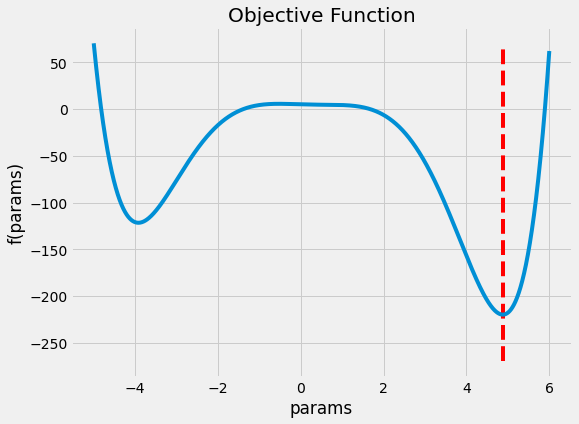

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y['loss'])
minx = x[np.argmin(y['loss'])]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('params'); plt.ylabel('f(params)')
plt.vlines(minx, min(y['loss'])- 50, max(y['loss']), linestyles = '--', colors = 'r')
plt.plot(x, y['loss']);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

### Domain


The domain is the values of ***params*** over which we evaluate the function. First we can use a uniform distribution over the space our function is defined.

Search space is where Hyperopt really gives you a ton of sampling options:
* for categorical parameters you have hp.choice
* for integers you get hp.randit, hp.quniform, hp.qloguniform and hp.qlognormal
* for floats we have hp.normal,  hp.uniform, hp.lognormal and hp.loguniform​

In [5]:
from hyperopt import hp

space = hp.uniform('x', -5, 6)

In [ ]:
#hyperspace for NN
space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                      {'layers':'three',
                        'units3': hp.uniform('units3', 64,1024), 
                        'dropout3': hp.uniform('dropout3', .25,.75)}
                    ]),

            'units1': hp.uniform('units1', 64, 1024),
            'units2': hp.uniform('units2', 64, 1024),

            'dropout1': hp.uniform('dropout1', .25,.75),
            'dropout2': hp.uniform('dropout2',  .25,.75),

            'batch_size' : hp.uniform('batch_size', 28,128),

            'nb_epochs' :  100,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

# Hyperparameter Optimization Algorithm

There are two choices for a hyperparameter optimization algorithm in Hyperopt: 
* random
* Tree Parzen Estimator

We can use both and compare the results. Using the suggest algorithm in these families automatically configures the algorithm for us.

In [26]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_algo = tpe.suggest
rand_algo = rand.suggest

### History runs
* Storing the history is as simple as making a Trials object that we pass into the function call. 
* This is not strictly necessary, but it gives us information that we can use to understand what the algorithm is doing.

In [27]:
from hyperopt import Trials

# Create two trials objects
tpe_trials = Trials()
rand_trials = Trials()


### Run the Optimization 


In [28]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

print(tpe_best)

# Run 2000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, 
                 max_evals=2000, rstate= np.random.RandomState(50))
print(rand_best)

100%|██████████| 2000/2000 [00:17<00:00, 115.25trial/s, best loss: -219.80118811219114]
{'x': 4.878481851906148}
100%|██████████| 2000/2000 [00:03<00:00, 508.10trial/s, best loss: -219.80116907646868]
{'x': 4.877613189834774}


In [29]:
# Print out information about losses
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(miny))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))

Minimum loss attained with TPE:    -219.8012
Minimum loss attained with random: -219.8012
Actual minimum of f(x):            -219.8012

Number of trials needed to attain minimum with TPE:    655
Number of trials needed to attain minimum with random: 235

Best value of x from TPE:    4.8785
Best value of x from random: 4.8776
Actual best value of x:      4.8779


In [30]:
# Results into a dataframe
import pandas as pd
import time

results = tpe_trials.results 
results_df = pd.DataFrame({'time': [x['time'] for x in results], 
                           'loss': [x['loss'] for x in results],
                           'x': [x['x'] for x in results],
                            'iteration': list(range(len(results)))})

# Sort with lowest loss on top
results_df = results_df.sort_values('loss', ascending = True)
results_df.head()


,time,loss,x,iteration
655,0.000034,-219.801188,4.878482,655
1369,0.000030,-219.801173,4.877646,1369
161,0.000029,-219.800919,4.879614,161
230,0.000029,-219.800612,4.875995,230
969,0.000033,-219.800430,4.880573,969


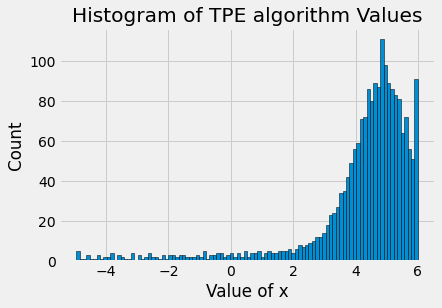

In [33]:
plt.hist(results_df['x'], bins = 100, edgecolor = 'k');
plt.title('Histogram of TPE algorithm Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

evaluated cluster much closer to the optimum